# Spatial spectra

Make wave-number spectra of various runs (based on Andrew's script https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/spectra/spectra.ipynb)

In [1]:
# import pyfftw # faster but not available - get this installed?
import numpy as np
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import copy
from scipy.fftpack import fft2, fftn, fftshift
import scipy.signal.windows as ssw
# import matplotlib.colors as colors
# import xarray as xr
# import netCDF4 as nc
# from tqdm import tqdm_notebook
# from mpl_toolkits.basemap import Basemap
# from calendar import month_abbr
# import cmocean as cm

from collections import OrderedDict

import sys, os
from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:40335 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 33.67 GB


In [18]:
figdir = 'spectra_figs/'
def savefigure(fname):
#    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=50, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=100, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
# Load session and define experiments
session = cc.database.create_session('/g/data/e14/rmh561/access-om2/archive/databases/cc_database_nummix.db')
exptdict = OrderedDict([
    ('01degRYF',   {'model':'ACCESS-OM2-01', 'expt':'01deg_jra55_ryf',
                 'usnap':'snapshot', 'tsnap':'snap',
                'n_files':-4, 'itime': None,'ftime':None}),
    ('01degRYFhv',   {'model':'ACCESS-OM2-01-hvisc', 'expt':'01deg_jra55v13_ryf9091_k_smag_iso3',
                 'usnap':'snapshot', 'tsnap':'snap',
                'n_files':-4, 'itime': None,'ftime':None}),
    ('025degRYF',   {'model':'ACCESS-OM2-025-RG', 'expt':'025deg_jra55_ryf_rediGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
    ('025degRYFnorediGM',   {'model':'ACCESS-OM2-025', 'expt':'025deg_jra55_ryf_norediGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
    ('025degRYFnoGM',   {'model':'ACCESS-OM2-025-R', 'expt':'025deg_jra55_ryf_noGM',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
    # ('025degRYF75',   {'model':'ACCESS-OM2-025-KDS75', 'expt':'025deg_jra55_ryf_kds75',
    #              'usnap':'snapshot', 'tsnap':'snapshot',
    #             'n_files':-1, 'itime': None,'ftime':None}),
    ('1degRYF',   {'model':'ACCESS-OM2-1-KDS50', 'expt':'1deg_jra55_ryf_kds50',
                 'usnap':'snapshot', 'tsnap':'snapshot',
                'n_files':-1, 'itime': None,'ftime':None}),
])

In [5]:
# location coords: [ minlon, maxlon, minlat, maxlat ]
# key names are used as filenames so should not have spaces
locations = { 
    'Gulf-Stream':             [-85,-50,25,45],
    'Kuroshio': [-240, -180, 25, 40],
    'Eastern-Tropical-Pacific': [-150, -100, -10, 10],
    'Southern-Ocean-Australia': [-250, -220, -60, -45], # Marine's region
    'Southern-Ocean-Pacific': [-180, -100, -65, -45]
}

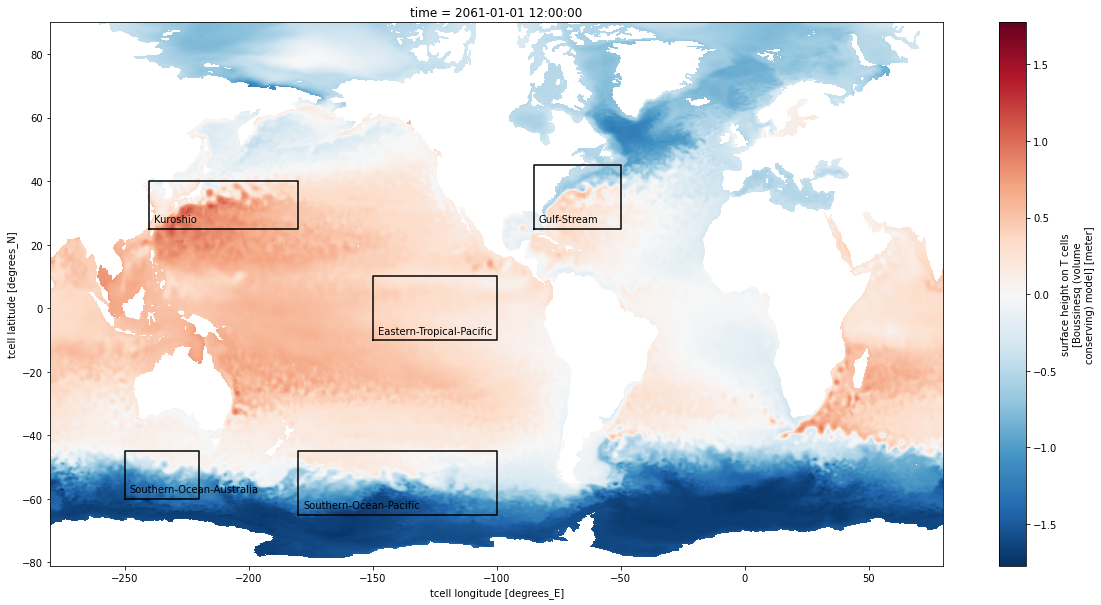

In [10]:
# Plot regions over SSH-variance plot from 1/10th
fig = plt.figure(figsize=(20,10),facecolor='w')

eta_t = cc.querying.getvar('01deg_jra55_ryf', 'eta_t', session, ncfile='ocean_daily.nc')
eta_t.isel(time=0).plot()
# SSHvar = (eta_t**2.).mean('time')-(eta_t.mean('time'))**2. # Doesn't work for some reason???
# SSHvar.plot()

for locname,loc in locations.items():
    plt.plot([loc[0], loc[1], loc[1], loc[0], loc[0]],[loc[2], loc[2], loc[3], loc[3], loc[2]],'-k')
    plt.text(loc[0]+2,loc[2]+2,locname)
savefigure('Regions')

In [11]:
# load model snapshots and grid data
data = copy.deepcopy(exptdict)  # this will store KE and temp fields under the same keys as exptdata.exptdict
for ekey in data.keys():
        expt = data[ekey]['expt']
        n_files = data[ekey]['n_files']
        usnap = 'ocean_' + data[ekey]['usnap'] + '.nc'
        tsnap = 'ocean_' + data[ekey]['tsnap'] + '.nc'
        
        try:
            data[ekey]['u'] = cc.querying.getvar(expt, 'u',session,n=n_files, ncfile=usnap).isel(st_ocean=0).fillna(0.0)
            data[ekey]['v'] = cc.querying.getvar(expt, 'v',session,n=n_files, ncfile=usnap).isel(st_ocean=0).fillna(0.0)
            
            # Load dxu, dyu vectors (NOTE: Below will not work in Tripolar region):
            # data[ekey]['dxu'] = cc.querying.getvar(expt,'dxu',session,n=-1, ncfile='ocean_grid.nc').mean('xu_ocean',skipna=True)
            # data[ekey]['dyu'] = cc.querying.getvar(expt,'dyu',session,n=-1, ncfile='ocean_grid.nc').mean('xu_ocean',skipna=True)        
            # Load area:
            # data[ekey]['area_u'] = cc.querying.getvar(expt,'area_u',session,n=-1, ncfile='ocean_grid.nc')
            
            sz = np.shape(data[ekey]['u'])
            print('Found ' + str(sz[0]) + ' snapshots of velocity for ' + data[ekey]['model'])
            
        except:
            print('Velocity snapshots not found ' + data[ekey]['model'])
        
        # Load SST and temperature at depth
        try:
            tmp = cc.querying.getvar(expt, 'temp',session,n=n_files, ncfile=tsnap)
            
            SST = tmp.isel(st_ocean=0)-273.15                  
            data[ekey]['SST'] = SST.fillna(0.0)
            
            T10 = tmp.sel(st_ocean=10.,method='nearest')-273.15                  
            data[ekey]['T10'] = T10.fillna(0.0)
            
            T100 = tmp.sel(st_ocean=100.,method='nearest')-273.15                  
            data[ekey]['T100'] = T100.fillna(0.0)
            T200 = tmp.sel(st_ocean=200.,method='nearest')-273.15                  
            data[ekey]['T200'] = T200.fillna(0.0)
            T300 = tmp.sel(st_ocean=300.,method='nearest')-273.15                  
            data[ekey]['T300'] = T300.fillna(0.0)
            T500 = tmp.sel(st_ocean=500.,method='nearest')-273.15                  
            data[ekey]['T500'] = T500.fillna(0.0)
            
            # Load dxu and dyu vectors (NOTE: Below will not work in Tripolar region):
            # data[ekey]['dxt'] = cc.querying.getvar(expt,'dxt',session,n=-1, ncfile='ocean_grid.nc').mean('xt_ocean',skipna=True)
            # data[ekey]['dyt'] = cc.querying.getvar(expt,'dyt',session,n=-1, ncfile='ocean_grid.nc').mean('xt_ocean',skipna=True)
            
            # Load area:
            # data[ekey]['area_t'] = cc.querying.getvar(expt,'area_t',session,n=-1, ncfile='ocean_grid.nc')
            
            sz = np.shape(data[ekey]['SST'])
            print('Found ' + str(sz[0]) + ' snapshots of temperature for ' + data[ekey]['model'])

        except:
            print('Temperature snapshots not found ' + data[ekey]['model'])

Found 12 snapshots of velocity for ACCESS-OM2-01


Found 4 snapshots of temperature for ACCESS-OM2-01


Found 12 snapshots of velocity for ACCESS-OM2-01-hvisc


Found 4 snapshots of temperature for ACCESS-OM2-01-hvisc
Found 24 snapshots of velocity for ACCESS-OM2-025-RG
Found 24 snapshots of temperature for ACCESS-OM2-025-RG


Found 24 snapshots of velocity for ACCESS-OM2-025
Found 24 snapshots of temperature for ACCESS-OM2-025


Found 24 snapshots of velocity for ACCESS-OM2-025-R
Found 24 snapshots of temperature for ACCESS-OM2-025-R


Found 120 snapshots of velocity for ACCESS-OM2-1-KDS50


Found 120 snapshots of temperature for ACCESS-OM2-1-KDS50


In [12]:
def detrend(f,dim):
    """
    Detrend multidimensional dataarray f in dimension dim.
    In all other dimensions, remove linear function from first to last element in dimension given by string dim.
    Follows method of Errico1985a sec 2a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
    WARNING: can produce a plaid pattern that produces artifacts in fft. Better to use window instead.
    
    cf. ArbicPolzinScottRichmanShriver2013a - they detrend with a 2d least-squares fit (this won't ensure periodicity but doesn't introduce spurious patterns)
    """
    # I don't like using eval but I can't think of a better way right now...
    first = eval('f.isel('+dim+'=0)')
    last = eval('f.isel('+dim+'=-1)')
    n = f[dim].size
    slope = (last-first)/(n-1)
    scale = xr.DataArray(np.arange((1-n)/2,(n+1)/2), coords={dim: f[dim]}, dims=[dim])
    return f-scale*slope # subtract outer product    

In [13]:
# DRAFTING INTERPOLATION TO UNIFORM GRID
#def interp_to_uniform(var,dx,dy,area):
#    """
#    Interpolate variable onto a grid with uniform grid-spacing.
#    """
# loc = locations['GulfStream']
# var = data['01degRYFhv']['SST'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1])).values
# dx = data['01degRYFhv']['dxt'].sel(yt_ocean=slice(loc[2],loc[3])).values
# dy = data['01degRYFhv']['dyt'].sel(yt_ocean=slice(loc[2],loc[3])).values
# area = data['01degRYFhv']['area_t'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1])).values
# X = np.tile(dx.T, (len(var[0,0,:]),1)).cumsum(axis=0)
# Y = np.tile(dy.T, (len(var[0,0,:]),1)).cumsum(axis=1)
# Lx = np.max(X)
# Ly = np.max(Y)
# Ly
#X = X.cumsum(axis=0)
#Y = Y.cumsum(axis=1)
#plt.pcolormesh(X.T,Y.T,X.T)
#np.shape(var)

In [14]:
def window(f,dim,window='hamming'):
    """
    Apply window to multidimensional dataarray f in dimension dim.
    
    cf. ArbicPolzinScottRichmanShriver2013a http://dx.doi.org/10.1175/JPO-D-11-0240.1
    - they detrend with a 2d least-squares fit before windowing (and use a different window function)
    ScottWang2005a do something similar
    TullochMarshallHillSmith2011a use flipping instead to ensure periodicity
    """
    return f*xr.DataArray(ssw.get_window(window, f[dim].size), coords={dim: f[dim]}, dims=[dim])

In [15]:
def azimuthal_sum(v2dtfft):  # following DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1
# NB: omits zero wavenumber
    dkh = np.max([np.max(np.diff(v2dtfft.ki)), np.max(np.diff(v2dtfft.kj))])
    dkmin = np.min([np.min(np.diff(v2dtfft.ki)), np.min(np.diff(v2dtfft.kj))])
    Nmax = int(np.ceil(np.sqrt(2)*max(v2dtfft.shape)/2))  # NB: extends sqrt(2) times further to get into corners
    kp = dkh*range(1,Nmax+1)
    C = 0.0*kp  # number of wavenumber points in each annulus (C in DurranWeynMenchaca2017a)
    v2dtfftradial = 0.0*kp
    radius = np.sqrt(v2dtfft.ki**2+v2dtfft.kj**2)
    ones = 1 + 0*v2dtfft
    
    # sum in each annulus
    for i,k in enumerate(kp):
        v2dtfftradial[i] = v2dtfft.where(radius>=k-dkh/2).where(radius<k+dkh/2).sum()
        C[i] = ones.where(radius>k-dkh/2).where(radius<=k+dkh/2).sum()

    v2dtfftradial *= dkmin  # scale as in eq (24) (assuming scaling in eq (22) is already done)

# eq (26): compensate for number of (k,l) pairs in each annulus
# NB: Parseval's theorem no longer exactly holds (p 3905)
    C = np.where(C==0, 1, C)  # ensures no division by zero (v2dtfftradial=0 there anyway)
    v2dtfftradial *= 2.0*np.pi*kp/C/dkmin

    v2dtfftradial = xr.DataArray(v2dtfftradial, dims=['k'], coords={'k': kp})
    # v2dtfftradial.k.attrs['units'] = 'cycles/dx'
    v2dtfftradial.k.attrs['units'] = 'radians/degree'
    v2dtfftradial.k.attrs['long_name'] = 'wavenumber magnitude'

# Truncate spectrum at Nyquist frequency (high k's in corners are anisotropically sampled):
# NB: Also breaks Parseval's theorem
    kminmax = np.min([np.max(v2dtfft.ki), np.max(v2dtfft.kj)])
    v2dtfftradial = v2dtfftradial.sel(k=slice(0.,kminmax))    

    return v2dtfftradial

In [16]:
def fft_KE(u,v):
    """
    0.5 * FFT squared magnitude (time-mean spectrum, in grid space).
    Coords are assumed to be t, y, x (in that order).
    """
    tdim, ydim, xdim = u.dims  # abstract out dimension names - NB: assumes this order of dimensions
    nx = u[xdim].size
    ny = u[ydim].size
    dx = np.max(np.diff(u[xdim]))
    dy = np.max(np.diff(u[ydim]))

# detrend data
    udt = detrend(detrend(u,xdim),ydim)  # don't use on its own - produces artifacts
    vdt = detrend(detrend(v,xdim),ydim)  # don't use on its own - produces artifacts
    udt = window(window(u,xdim),ydim)
    vdt = window(window(v,xdim),ydim)

    udt -= udt.mean(xdim, skipna=True).mean(ydim, skipna=True)  # remove mean at each time
    vdt -= vdt.mean(xdim, skipna=True).mean(ydim, skipna=True)

# FFTs:
    udtfft = fftn(udt.values, axes=(1,2))  # fft amplitude at each time
    vdtfft = fftn(vdt.values, axes=(1,2))

    KEdtfft = (udtfft*udtfft.conjugate()+vdtfft*vdtfft.conjugate()).real  # squared magnitude
    KEdtfft = KEdtfft.mean(axis=0)  # time-mean
    KEdtfft[0,0] = np.nan  # nan at removed zero frequency
    KEdtfft = fftshift(KEdtfft)  # put zero wavenumber in array centre
    KEdtfft *= dx*dy/(8.0*(np.pi)**2*nx*ny)  # scaling as per eq (22) of DurranWeynMenchaca2017a http://dx.doi.org/10.1175/MWR-D-17-0056.1

    # set up metadata
    # k in units rads/(units of dx)
    KEdtfft = xr.DataArray(KEdtfft, dims=['kj','ki'], 
                coords={'kj': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny)*(2*np.pi/dy), 
                        'ki': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)*(2*np.pi/dx)},
                attrs={'long_name': 'wavenumber spectrum in grid units'})
    KEdtfft.ki.attrs['units'] = 'radians/degree longitude'
    KEdtfft.kj.attrs['units'] = 'radians/degree latitude'
    # k in units cycles/dx:
    # KEdtfft = xr.DataArray(KEdtfft, dims=['kj','ki'], 
    #             coords={'kj': np.linspace(-0.5, 0.5+(ny%2-1)/ny, num=ny)*(2*np.pi/dy), 
    #                     'ki': np.linspace(-0.5, 0.5+(nx%2-1)/nx, num=nx)*(2*np.pi/dx)},
    #             attrs={'long_name': 'wavenumber spectrum in grid units'})
    # KEdtfft.ki.attrs['units'] = 'cycles/dx'
    # KEdtfft.kj.attrs['units'] = 'cycles/dy'
    KEdtfft.ki.attrs['long_name'] = 'x wavenumber'
    KEdtfft.kj.attrs['long_name'] = 'y wavenumber'

    return KEdtfft

In [17]:
# Calc and save radial spectra 
for locname,loc in locations.items():
    # fig = plt.figure(figsize=(12,5.5*len(data.keys())),facecolor='w')
    # cnt = 0
    for ekey in data.keys():
        # ax1 = plt.subplot(len(data.keys()),2,1+2*cnt)
        # ax2 = plt.subplot(len(data.keys()),2,2+2*cnt)
        # cnt = cnt+1
        print('Calculating spectra ' + data[ekey]['model'] + ' ' + locname)
        # try:
        u = data[ekey]['u'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
        v = data[ekey]['v'].sel(yu_ocean=slice(loc[2],loc[3])).sel(xu_ocean=slice(loc[0],loc[1]))
            # ((u**2.+v**2.)/2.).isel(time=0).plot(ax=ax1,vmin=0.,vmax=2.)
            # ax1.set_title(locname+' surface KE, '+data[ekey]['model'])

        kefft = fft_KE(u,v)
        kefftradial = azimuthal_sum(kefft)
        data[ekey][locname+'_kefftradial'] = kefftradial
        # except:
        #     print('Velocity snapshots not found ' + data[ekey]['model'] + ' ' + locname)
            
        # try:
        #     SST = data[ekey]['SST'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
        #     T10 = data[ekey]['T10'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
        #     T100 = data[ekey]['T100'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
        #     T200 = data[ekey]['T200'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
        #     T300 = data[ekey]['T300'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
        #     T500 = data[ekey]['T500'].sel(yt_ocean=slice(loc[2],loc[3])).sel(xt_ocean=slice(loc[0],loc[1]))
            
        #     SST.isel(time=0).plot(ax=ax2,vmin=10.,vmax=25.)
        #     ax2.set_title(locname+' SST, '+data[ekey]['model'])

        #     SSTfft = fftgrid(SST)
        #     SSTfftradial = azimuthal_sum(SSTfft)
        #     data[ekey]['SSTfftradial'] = SSTfftradial
            
        #     T10fft = fftgrid(T10)
        #     T10fftradial = azimuthal_sum(T10fft)
        #     data[ekey]['T10fftradial'] = T10fftradial
            
        #     T100fft = fftgrid(T100)
        #     T100fftradial = azimuthal_sum(T100fft)
        #     data[ekey]['T100fftradial'] = T100fftradial
            
        #     T200fft = fftgrid(T200)
        #     T200fftradial = azimuthal_sum(T200fft)
        #     data[ekey]['T200fftradial'] = T200fftradial
            
        #     T300fft = fftgrid(T300)
        #     T300fftradial = azimuthal_sum(T300fft)
        #     data[ekey]['T300fftradial'] = T300fftradial
            
        #     T500fft = fftgrid(T500)
        #     T500fftradial = azimuthal_sum(T500fft)
        #     data[ekey]['T500fftradial'] = T500fftradial
        #     # fig2 = plt.figure(figsize=(12,8))
        #     # np.log(SSTfft).plot()  # xlim=(-0.05,0.05),ylim=(-0.05,0.05))
        #     # plt.title(locname+' log of time-mean SST FFT amplitude, '+data[ekey]['model'])

            
        # except:
        #     print('Temperature snapshots not found ' + data[ekey]['model'])

Calculating spectra ACCESS-OM2-01 Gulf-Stream


Calculating spectra ACCESS-OM2-01-hvisc Gulf-Stream


Calculating spectra ACCESS-OM2-025-RG Gulf-Stream


Calculating spectra ACCESS-OM2-025 Gulf-Stream


Calculating spectra ACCESS-OM2-025-R Gulf-Stream


Calculating spectra ACCESS-OM2-1-KDS50 Gulf-Stream


Calculating spectra ACCESS-OM2-01 Kuroshio


Calculating spectra ACCESS-OM2-01-hvisc Kuroshio


Calculating spectra ACCESS-OM2-025-RG Kuroshio


Calculating spectra ACCESS-OM2-025 Kuroshio


Calculating spectra ACCESS-OM2-025-R Kuroshio


Calculating spectra ACCESS-OM2-1-KDS50 Kuroshio


Calculating spectra ACCESS-OM2-01 Eastern-Tropical-Pacific


Calculating spectra ACCESS-OM2-01-hvisc Eastern-Tropical-Pacific


Calculating spectra ACCESS-OM2-025-RG Eastern-Tropical-Pacific


Calculating spectra ACCESS-OM2-025 Eastern-Tropical-Pacific


Calculating spectra ACCESS-OM2-025-R Eastern-Tropical-Pacific


Calculating spectra ACCESS-OM2-1-KDS50 Eastern-Tropical-Pacific


Calculating spectra ACCESS-OM2-01 Southern-Ocean-Australia


Calculating spectra ACCESS-OM2-01-hvisc Southern-Ocean-Australia


Calculating spectra ACCESS-OM2-025-RG Southern-Ocean-Australia


Calculating spectra ACCESS-OM2-025 Southern-Ocean-Australia


Calculating spectra ACCESS-OM2-025-R Southern-Ocean-Australia


Calculating spectra ACCESS-OM2-1-KDS50 Southern-Ocean-Australia


Calculating spectra ACCESS-OM2-01 Southern-Ocean-Pacific


Calculating spectra ACCESS-OM2-01-hvisc Southern-Ocean-Pacific


Calculating spectra ACCESS-OM2-025-RG Southern-Ocean-Pacific


Calculating spectra ACCESS-OM2-025 Southern-Ocean-Pacific


Calculating spectra ACCESS-OM2-025-R Southern-Ocean-Pacific


Calculating spectra ACCESS-OM2-1-KDS50 Southern-Ocean-Pacific


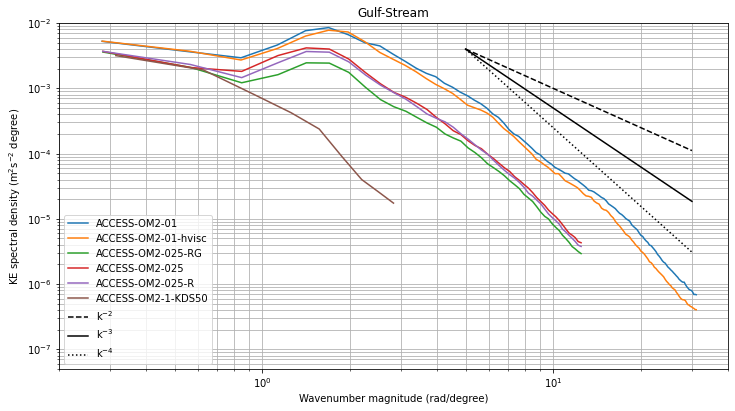

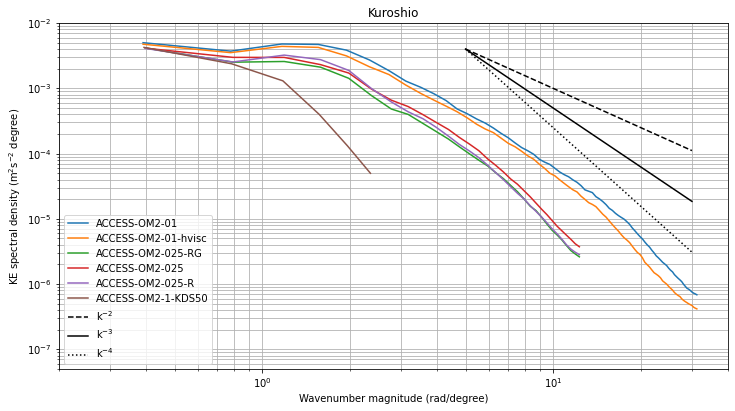

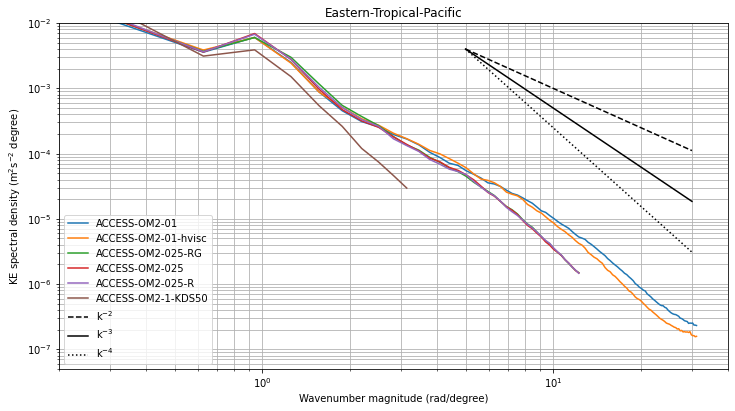

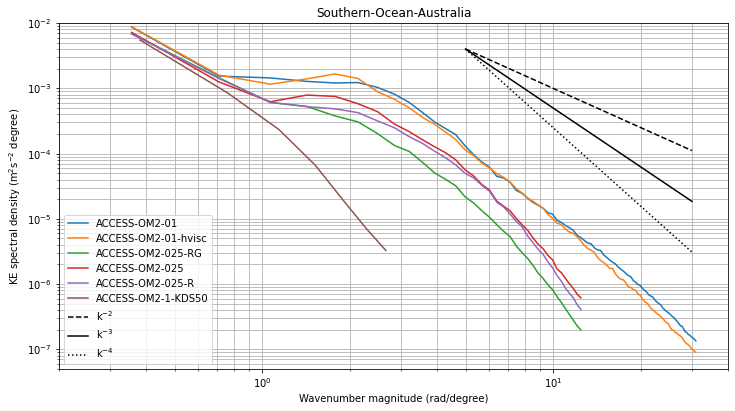

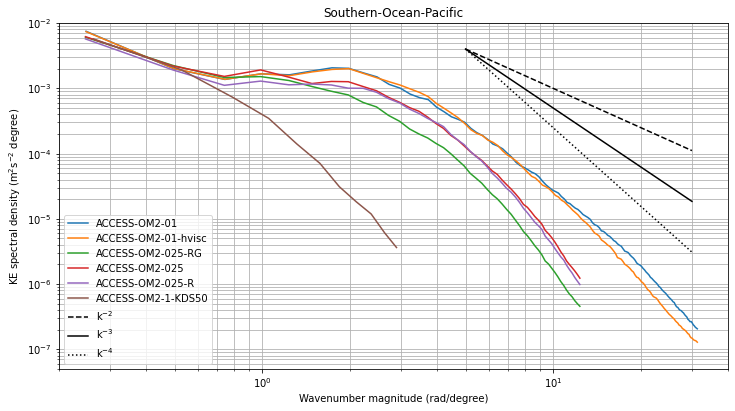

In [21]:
# Plot spectra together:            
for locname,loc in locations.items():
# locname='GulfStream'
# loc = locations[locname]

    fig3 = plt.figure(figsize=(12,14),facecolor='w')
    axs1 = plt.subplot(2,1,1)
    #axs2 = plt.subplot(2,1,2)
    cnt=0
    for ekey in data.keys():
        col = 'C' + str(cnt)
        cnt = cnt+1
        try:
            kefftradial = data[ekey][locname+'_kefftradial']
            kefftradial.plot(ax=axs1, xscale='log', yscale='log',label=data[ekey]['model'],color=col)
            axs1.set_title(locname)
            axs1.set_ylabel('KE spectral density (m$^2$s$^{-2}$ degree)')
            axs1.set_xlabel('Wavenumber magnitude (rad/degree)')
        except:
            print('KE spectra not plotted ' + data[ekey]['model'])
        # try:          
        #     SSTfftradial = data[ekey]['SSTfftradial']
        #     #SSTfftradial.plot(ax=axs2, xscale='log', yscale='log',label=data[ekey]['model'],color=col)

        #     # data[ekey]['T10fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle='--',color=col)
        #     # data[ekey]['T100fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle='--',color=col)
        #     # data[ekey]['T200fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle='--',color=col)
        #     data[ekey]['T300fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle='-',color=col,label=data[ekey]['model'],)
        #     #data[ekey]['T500fftradial'].plot(ax=axs2, xscale='log', yscale='log', linestyle=':',color=col)
        #     axs2.set_title(locname+' time-mean 300m Temperature FFT amplitude')

        # except:
        #     print('SST spectra not plotted ' + data[ekey]['model'])

    # Add example spectral slopes:
    ks = [5.e0,3.e1]
    E1 = 4.e-3
    axs1.plot(ks,[E1*(k/ks[0])**(-2) for k in ks],'--k',label='k$^{-2}$')
    axs1.plot(ks,[E1*(k/ks[0])**(-3.) for k in ks],'-k',label='k$^{-3}$')
    #axs1.plot(ks,[E1*(k/ks[0])**(-5./3.) for k in ks],':k',label='k$^{-5/3}$')
    axs1.plot(ks,[E1*(k/ks[0])**(-4) for k in ks],':k',label='k$^{-4}$')
    axs1.grid(which='both', axis='both')
    axs1.legend()
    axs1.set_ylim([5.e-8,1.e-2])
    axs1.set_xlim([2.e-1,0.4e2])
    savefigure(locname+'KE_Spectra')


# TODO
- Compensate for variance reduction from windowing?
- interpolate onto grid in units of metres (choose a power of 2)
- remove trends from interpolated data - see Errico1985a http://dx.doi.org/10.1175/1520-0493(1985)113<1554:SCFALA>2.0.CO;2
- remove mean (do this with interpolated data so it is area-weighted)


2D fft sum = 2.55e-01
Radial fft sum = 2.12e-01
Spatial sum = 2.59e-01


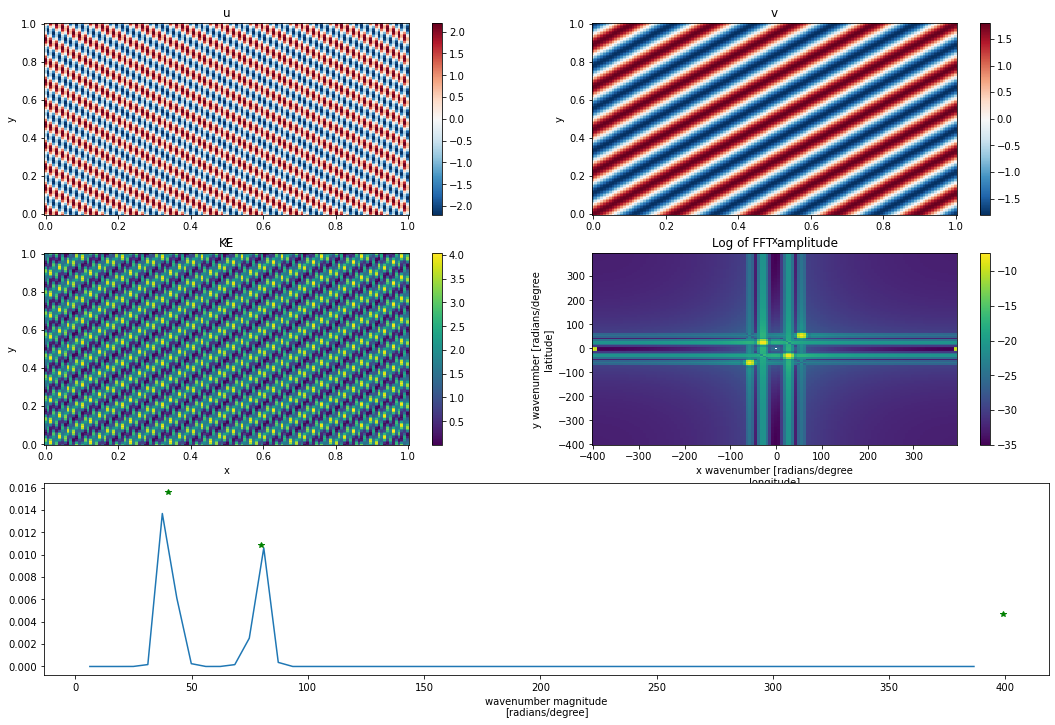

In [72]:
# Testing with dummy data

# dimensions
nx, ny = 128, 128
x, y = np.linspace(0.,1.,nx),np.linspace(0.,1.,ny)
dx, dy = np.max(np.diff(x)), np.max(np.diff(y))
X, Y = np.meshgrid(x,y)
t = [0]

# dummy solution
k1, k2, kx = 2.*np.pi/(10.*dx), 2.*np.pi/(20.*dx), 2.*np.pi/(2.*dx)
a1, a2, a3 = 1.5, 1.8, 0.7
u, v = np.zeros((1,ny,nx)), np.zeros((1,ny,nx))
u[0,:,:] = a1*np.sin(k1*(X+Y)/np.sqrt(2.))+a3*np.cos(kx*X)
v[0,:,:] = a2*np.cos(k2*(X-Y)/np.sqrt(2.))-a3*np.sin(kx*X)
u = xr.DataArray(u,coords=[t,y,x],dims=['t','y','x'])
v = xr.DataArray(v,coords=[t,y,x],dims=['t','y','x'])

# Calc spectra:
fft = fft_KE(u,v)
fftradial = azimuthal_sum(fft)

dki, dkj = np.max(np.diff(fft.ki)), np.max(np.diff(fft.kj))
dkh = np.max(np.diff(fftradial.k))

# check Parseval's theorem
# fft2dsum = fft.sum().sum()*dki*dkj*(2*np.pi/dx)*(2*np.pi/dy) # Extra factors convert k in (cycles/dx) to k in (radians)
# fftrsum = fftradial.sum().sum()*dkh*(2*np.pi/dx)*(2*np.pi/dy) # won't hold exactly if eq (26) applied in azimuthal_sum
fft2dsum = fft.sum().sum()*dki*dkj
fftrsum = fftradial.sum().sum()*dkh
print('2D fft sum = %3.2e' % fft2dsum)
print('Radial fft sum = %3.2e' % fftrsum)

# Spatial sum
uw, vw = window(window(u,'x'),'y'), window(window(v,'x'),'y')
uw -= uw.mean('x', skipna=True).mean('y', skipna=True)  # remove mean at each time
vw -= vw.mean('x', skipna=True).mean('y', skipna=True)  # remove mean at each time
spsum = ((uw**2.+vw**2.)/2.).sum().sum()*dx*dy/1./1.
print('Spatial sum = %3.2e' % spsum)

fig2 = plt.figure(figsize=(18,12),facecolor='w')
plt.subplot(3,2,1)
u.plot()
plt.title('u')
plt.subplot(3,2,2)
v.plot()
plt.title('v')
plt.subplot(3,2,3)
((u**2.+v**2)/2.).plot()
plt.title('KE')
plt.subplot(3,2,4)
np.log(fft).plot()
plt.title('Log of FFT amplitude')
plt.subplot(3,2,(5,6))
fftradial.plot()

plt.plot([k1],[a1**2*dki*dkj*dx*dy*2],'*g')
plt.plot([k2],[a2**2*dki*dkj*dx*dy*2],'*g')
plt.plot([kx],[2.*a3**2*dki*dkj*dx*dy*2],'*g')

# plt.grid()